# Extracting Files

In [1]:
import shutil
shutil.unpack_archive('../input/dicom-files-to-rgb-mag-edge1-edge2-512x512/SIIM-FISABIO-RSNA-JPEG.zip', './')

# Modules and DataLoader

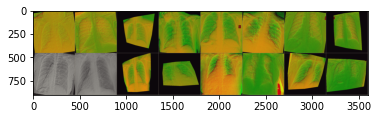

In [2]:
'''
We write this code with the help of PyTorch demo:
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
  
'''

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import random


RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop((470,470)),
        transforms.RandomRotation(10,),
        transforms.RandomPerspective(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.CenterCrop((448,448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'val': transforms.Compose([
        transforms.Resize(448),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize(448),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = './'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#plt.rcParams['font.size'] = '12'
#plt.rcParams['figure.dpi'] = 600

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.savefig('Augmented_data_train.pdf')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

# Models

In [3]:
#%%

#model_ft = models.vgg11_bn(pretrained=True)
#num_ftrs = model_ft.classifier[0].in_features

model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 20
Num_class=2


'''
Changing the fully connected layer 
'''

model_ft.fc = nn.Linear(num_ftrs, Num_class)


Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

# Training Function

In [4]:
def train_model_phase(model, criterion, optimizer, scheduler, phase):
    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    if phase == 'train':
        scheduler.step()

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    
    
    return model, epoch_loss, epoch_acc

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token = 0
            
            model, epoch_loss, epoch_acc = train_model_phase(model, criterion, optimizer, scheduler, phase)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token = 1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training lr = 0.01

In [5]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

Epoch 1/5
----------
train Loss: 0.7050 Acc: 0.6528
val Loss: 0.9218 Acc: 0.6424
test Loss: 0.8673 Acc: 0.6551

Epoch 2/5
----------
train Loss: 0.6351 Acc: 0.6885
val Loss: 0.7652 Acc: 0.5728

Epoch 3/5
----------
train Loss: 0.5916 Acc: 0.7080
val Loss: 0.4939 Acc: 0.7595
test Loss: 0.5071 Acc: 0.7627

Epoch 4/5
----------
train Loss: 0.5683 Acc: 0.7233
val Loss: 0.5018 Acc: 0.7690
test Loss: 0.5107 Acc: 0.7690

Epoch 5/5
----------
train Loss: 0.5621 Acc: 0.7294
val Loss: 0.4920 Acc: 0.7785
test Loss: 0.5111 Acc: 0.7500

Training complete in 55m 16s
Best val Acc: 0.778481


# Training lr = 0.001

In [6]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=5)

Epoch 1/5
----------
train Loss: 0.5186 Acc: 0.7580
val Loss: 0.4819 Acc: 0.7722
test Loss: 0.4863 Acc: 0.7690

Epoch 2/5
----------
train Loss: 0.5097 Acc: 0.7645
val Loss: 0.4724 Acc: 0.7816
test Loss: 0.4770 Acc: 0.7690

Epoch 3/5
----------
train Loss: 0.4995 Acc: 0.7653
val Loss: 0.4641 Acc: 0.7722

Epoch 4/5
----------
train Loss: 0.4995 Acc: 0.7687
val Loss: 0.4634 Acc: 0.7785

Epoch 5/5
----------
train Loss: 0.4914 Acc: 0.7722
val Loss: 0.4498 Acc: 0.7816

Training complete in 54m 44s
Best val Acc: 0.781646


# Confusion Matrix

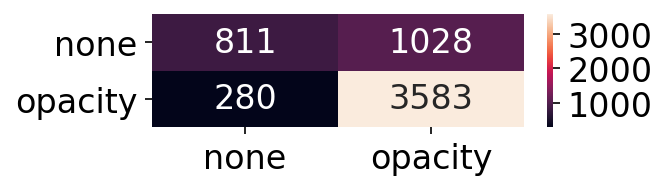

In [7]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output_all.extend(output.data.cpu().numpy())

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('none', 'opacity')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (4,1),dpi=150)
plt.rcParams['font.size'] = '16'
sn.heatmap(df_cm, annot=True, fmt=".0f")

with open('train.npy', 'wb') as f:
    np.save(f, output_all)
    np.save(f, y_true)
#with open('test.npy', 'rb') as f:
#    a = np.load(f)
#    b = np.load(f)
#print(a, b)

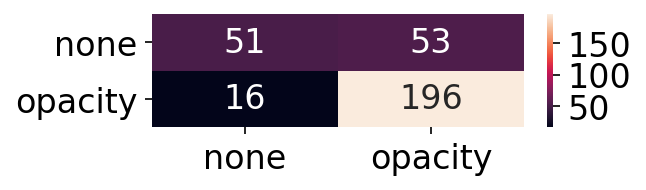

In [8]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output_all.extend(output.data.cpu().numpy())

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (4,1),dpi=150)
plt.rcParams['font.size'] = '16'
sn.heatmap(df_cm, annot=True, fmt=".0f")

with open('val.npy', 'wb') as f:
    np.save(f, output_all)
    np.save(f, y_true)

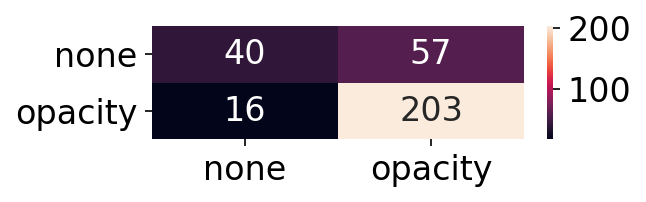

In [9]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output_all.extend(output.data.cpu().numpy())

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (4,1),dpi=150)
plt.rcParams['font.size'] = '16'
sn.heatmap(df_cm, annot=True, fmt=".0f")

with open('test.npy', 'wb') as f:
    np.save(f, output_all)
    np.save(f, y_true)

# Saving FC

In [10]:
best_net_FC = model_ft.fc

PATH = "./best_model_fc.pt"
torch.save(best_net_FC.state_dict(), PATH)


'''
#Guideline for loading model in future 

import sys
sys.modules[__name__].__dict__.clear()

device = torch.device('cpu')

model_ft = models.wide_resnet101_2(pretrained=True)
model_fc = nn.Linear(num_ftrs, 2)

model_fc.load_state_dict(torch.load(PATH, map_location=device))
model_ft.fc = model_fc

'''

"\n#Guideline for loading model in future \n\nimport sys\nsys.modules[__name__].__dict__.clear()\n\ndevice = torch.device('cpu')\n\nmodel_ft = models.wide_resnet101_2(pretrained=True)\nmodel_fc = nn.Linear(num_ftrs, 2)\n\nmodel_fc.load_state_dict(torch.load(PATH, map_location=device))\nmodel_ft.fc = model_fc\n\n"

# Delete Extracted Images

In [11]:
shutil.rmtree('./train')
shutil.rmtree('./val')
shutil.rmtree('./test')